In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, Dropout, TimeDistributed, Activation, RepeatVector, Concatenate
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import string

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import cv2, warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Add, Dropout, LSTM, TimeDistributed, Embedding, RepeatVector, Concatenate, Bidirectional, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
img_path = '/content/drive/MyDrive/DSEM_Project/Flickr8k_Dataset/'
images = glob(img_path+'*.jpg')
images[:5]

['/content/drive/MyDrive/DSEM_Project/Flickr8k_Dataset/405534893_2d0f3b0147.jpg',
 '/content/drive/MyDrive/DSEM_Project/Flickr8k_Dataset/391579205_c8373b5411.jpg',
 '/content/drive/MyDrive/DSEM_Project/Flickr8k_Dataset/399212516_d68046b277.jpg',
 '/content/drive/MyDrive/DSEM_Project/Flickr8k_Dataset/3736786640_70df13be2c.jpg',
 '/content/drive/MyDrive/DSEM_Project/Flickr8k_Dataset/3751594676_edfbfa0688.jpg']

In [5]:
len(images)

8121

In [6]:
captions = open('/content/drive/MyDrive/DSEM_Project/Flickr8_text/captions.txt','rb').read().decode('utf-8').split('\n')
captions[:5]

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']

In [7]:
len(captions)

40457

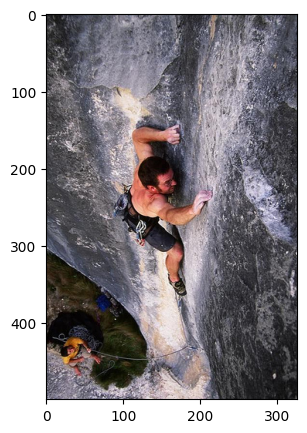

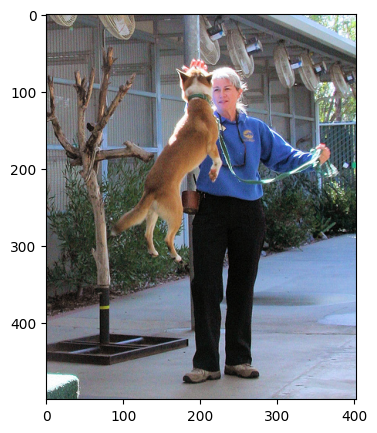

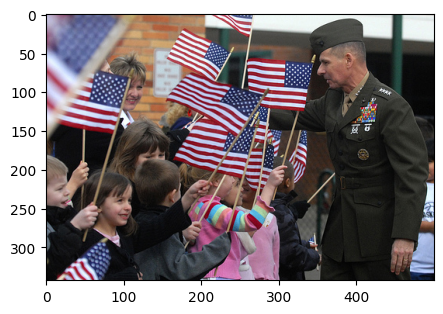

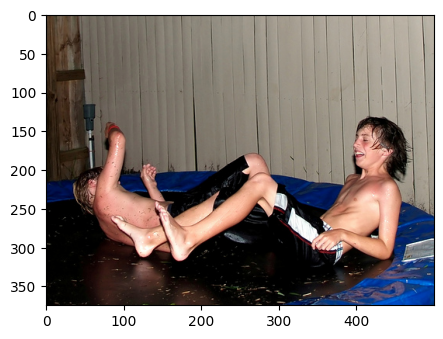

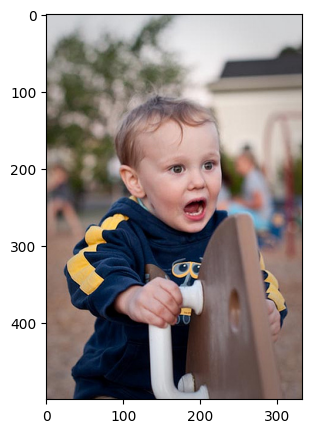

In [8]:
for i in range(5):
    plt.figure(figsize=(5,5))
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img);

In [9]:
inception_model = ResNet50(include_top=True)
inception_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
last = inception_model.layers[-2].output
model = Model(inputs=inception_model.input,outputs=last)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
img_features = {}
count = 0

for img_path in tqdm(images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224)) # ResNet model requires images of dimensions (224,224,3)
    img = img.reshape(1,224,224,3) # Reshaping image to the dimensions of a single image
    features = model.predict(img).reshape(2048,) # Feature extraction from images
    img_name = img_path.split('/')[-1] # Extracting image name
    img_features[img_name] = features
    count += 1
    # Fetching the features of only 1500 images as using more than 1500 images leads to overloading memory issues
    if count == 1500:
        break
    if count % 50 == 0:
        print(count)


  0%|          | 0/8121 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
50
1/1 [==============================] - 0s 31ms/step
100
1/1 [==============================] - 0s 24ms/step
150
1/1 [==============================] - 0s 30ms/step
200
1/1 [==============================] - 0s 24ms/step
250
1/1 [==============================] - 0s 33ms/step
300
1/1 [==============================] - 0s 23ms/step
350
1/1 [==============================] - 0s 25ms/step
400
1/1 [==============================] - 0s 34ms/step
450
1/1 [==============================] - 0s 22ms/step
500
1/1 [==============================] - 0s 25ms/step
550
1/1 [==============================] - 0s 33ms/step
600
1/1 [==============================] - 0s 22ms/step
650
1/1 [==============================] - 0s 23ms/step
700
1/1 [==============================] - 0s 37ms/step
750
1/1 [==============================] - 0s 23ms/step
800
1/1 [==============================] - 0s 24ms/step
850
1/1 [==============================] - 0s 36ms/st

In [12]:
len(img_features)

1500

In [13]:
captions = captions[1:]
captions[:12]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a 

In [52]:
print(captions)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
captions[8].split(',')[1]



'Two dogs of different breeds looking at each other on the road .'

In [15]:
captions_dict = {}

for cap in captions:
    try:
        img_name = cap.split(',')[0]
        caption = cap.split(',')[1]
        # Each image has 5 captions
        if img_name in img_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption] # Storing the first caption
            else:
                captions_dict[img_name].append(caption) # Adding the remaining captions 
    except:
        break

In [51]:
print(captions_dict)

{'3507076266_8b17993fbb.jpg': [[1, 2, 3, 4, 2, 5, 6, 7, 8, 2, 9, 10, 11, 12, 13], [1, 2, 3, 14, 2, 15, 9, 11, 12, 13], [1, 3, 4, 5, 6, 8, 9, 11, 13], [1, 3, 16, 2, 9, 17, 11, 18, 19, 20, 12, 13], [1, 21, 3, 7, 14, 22, 2, 23, 11, 13]], '3507670136_2e5f94accf.jpg': [[1, 2, 24, 25, 7, 26, 2, 15, 27, 28, 2, 29, 30, 12, 13], [1, 2, 3, 4, 29, 31, 2, 32, 33, 12, 13], [1, 2, 34, 32, 7, 35, 36, 21, 37, 38, 2, 24, 39, 12, 13], [1, 2, 40, 28, 29, 7, 26, 2, 27, 41, 2, 24, 32, 12, 13], [1, 21, 42, 43, 4, 2, 29, 44, 7, 4, 45, 12, 13]], '3509611207_7645b1d28d.jpg': [[1, 2, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 48, 2, 56, 12, 13], [1, 57, 58, 59, 49, 22, 60, 61, 4, 62, 48, 2, 63, 64, 56, 65, 2, 66, 14, 4, 21, 67, 12, 13], [1, 59, 49, 22, 60, 68, 69, 70, 71, 72, 41, 73, 74, 12, 13], [1, 59, 75, 58, 14, 36, 21, 76, 4, 2, 77, 78, 79, 12, 13], [1, 80, 75, 22, 81, 82, 83, 13]], '3510219078_670b6b3157.jpg': [[1, 2, 9, 84, 65, 2, 5, 65, 85, 84, 86, 65, 87, 12, 13], [1, 2, 9, 84, 88, 2, 5, 65, 85, 84, 89, 9

In [17]:
def text_preprocess(text):
    modified_text = text.lower() # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq' # Appending the special tokens at the beginning and ending of text
    return modified_text

In [18]:
# Storing the preprocessed text within the captions dictionary
for key, val in captions_dict.items():
    for item in val:
        captions_dict[key][val.index(item)] = text_preprocess(item)

Creating vocabulary of the entire text corpus

In [19]:
count_words = dict()
cnt = 1

for key, val in captions_dict.items(): # Iterating through all images with keys as images and their values as 5 captions
    for item in val: # Iterating through all captions for each image
        for word in item.split(): # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1

In [20]:
len(count_words) 

3897

In [21]:
# Encoding the text by assigning each word to its corresponding index in the vocabulary i.e. count_words dictionary
for key, val in captions_dict.items():
    for caption in val:
        encoded = []
        for word in caption.split():
            encoded.append(count_words[word])
        captions_dict[key][val.index(caption)] = encoded

In [22]:
max_len = -1

for key, value in captions_dict.items():
    for caption in value:
        if max_len < len(caption):
            max_len = len(caption)

In [23]:
max_len

34

In [24]:
vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
vocab_size

3897

Building a custom generator function to generate input image features, previously generated text and the text to be generated as output

In [25]:
def generator(img,caption):
    n_samples = 0
    X = []
    y_input = []
    y_output = []
    
    for key, val in caption.items(): 
        for item in val: 
            for i in range(1,len(item)):
                X.append(img[key]) # Appending the input image features
                input_seq = [item[:i]] # Previously generated text to be used as input to predict the next word 
                output_seq = item[i] # The next word to be predicted as output
                # Padding encoded text sequences to the maximum length
                input_seq = pad_sequences(input_seq,maxlen=max_len,padding='post',truncating='post')[0] 
                # One Hot encoding the output sequence with vocabulary size as the total no. of classes
                output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
                y_input.append(input_seq)
                y_output.append(output_seq)
    
    return X, y_input, y_output

In [26]:
X, y_in, y_out = generator(img_features,captions_dict)

In [27]:
len(X), len(y_in), len(y_out)

(91647, 91647, 91647)

In [28]:
# Converting input and output into Numpy arrays for faster processing
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

In [29]:
X.shape, y_in.shape, y_out.shape

((91647, 2048), (91647, 34), (91647, 3898))

In [30]:
from keras.layers import GRU

In [31]:
embedding_len = 128
MAX_LEN = max_len
vocab_size = len(count_words)

# Model for image feature extraction
img_model = Sequential()
img_model.add(Dense(embedding_len,input_shape=(2048,),activation='relu'))
img_model.add(RepeatVector(MAX_LEN))

img_model.summary()

# Model for generating captions from image features
captions_model = Sequential()
captions_model.add(Embedding(input_dim=vocab_size+1,output_dim=embedding_len,input_length=MAX_LEN))
captions_model.add(GRU(256,return_sequences=True))
captions_model.add(TimeDistributed(Dense(embedding_len)))

captions_model.summary()

# Concatenating the outputs of image and caption models
concat_output = Concatenate()([img_model.output,captions_model.output])
# First GRU Layer
output = GRU(units=128,return_sequences=True)(concat_output)
# Second GRU Layer
output = GRU(units=512,return_sequences=False)(output)
# Output Layer 
output = Dense(units=vocab_size+1,activation='softmax')(output)
# Creating the final model
final_model = Model(inputs=[img_model.input,captions_model.input],outputs=output)
final_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics='accuracy')
final_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 34, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 128)           498944    
                                                                 
 gru (GRU)                   (None, 34, 256)           296448    
                            

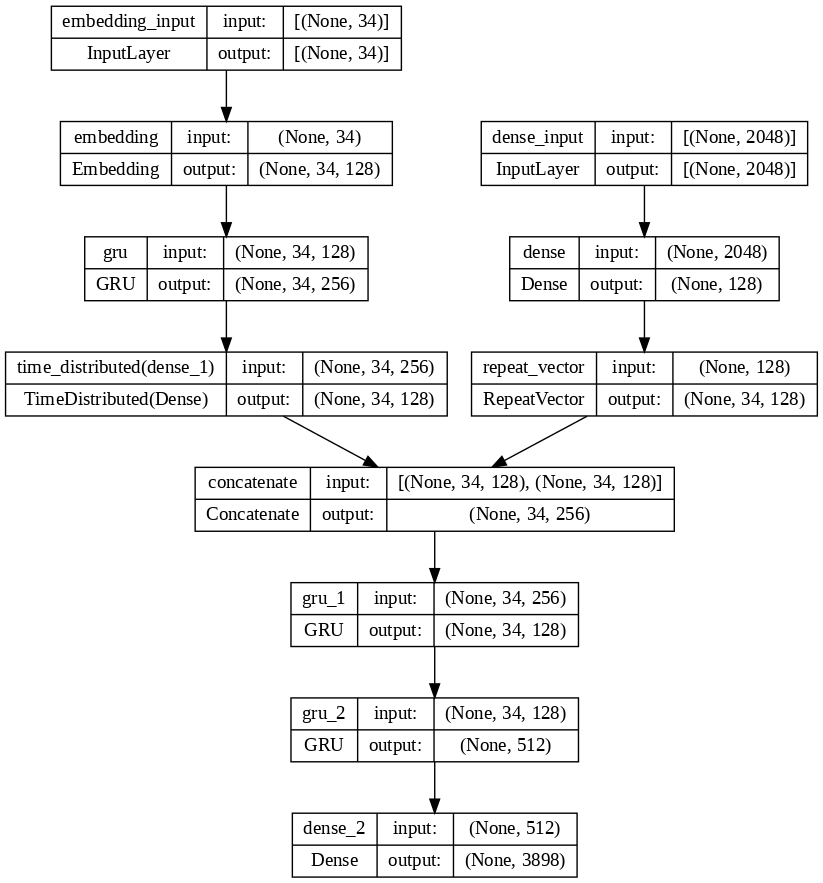

In [32]:
plot_model(final_model,'model.png',show_shapes=True,dpi=100)

In [33]:
mc = ModelCheckpoint('image_caption_generator.h5',monitor='accuracy',verbose=1,mode='max',save_best_only=True)

final_model.fit([X,y_in],
                y_out,
                batch_size=512,
                callbacks=mc,
                epochs=200)

Epoch 1/200
179/179 [==============================] - ETA: 0s - loss: 5.2556 - accuracy: 0.1091
Epoch 1: accuracy improved from -inf to 0.10910, saving model to image_caption_generator.h5
179/179 [==============================] - 32s 126ms/step - loss: 5.2556 - accuracy: 0.1091
Epoch 2/200
179/179 [==============================] - ETA: 0s - loss: 4.9870 - accuracy: 0.1171
Epoch 2: accuracy improved from 0.10910 to 0.11709, saving model to image_caption_generator.h5
179/179 [==============================] - 14s 77ms/step - loss: 4.9870 - accuracy: 0.1171
Epoch 3/200
179/179 [==============================] - ETA: 0s - loss: 4.8183 - accuracy: 0.1167
Epoch 3: accuracy did not improve from 0.11709
179/179 [==============================] - 12s 69ms/step - loss: 4.8183 - accuracy: 0.1167
Epoch 4/200
179/179 [==============================] - ETA: 0s - loss: 4.6769 - accuracy: 0.1179
Epoch 4: accuracy improved from 0.11709 to 0.11790, saving model to image_caption_generator.h5
179/179 [

In [34]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_dict = {val: key for key,val in count_words.items()}

Saved the final trained model & the vocabulary dictionary

In [35]:
final_model.save('image_caption_generator.h5')

In [36]:
np.save('vocab.npy',count_words)

Generating sample predictions

In [37]:
# Custom function for extracting an image and transforming it into an appropriate format
def getImage(idx):
    test_img_path = images[idx]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.reshape(test_img,(1,224,224,3))
    return test_img


1/1 [==============================] - 0s 22ms/step


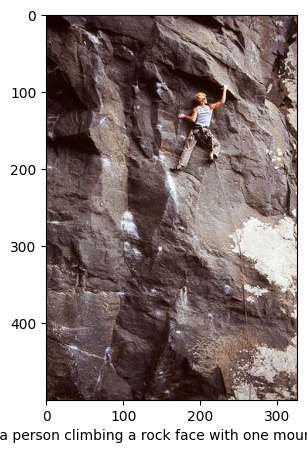

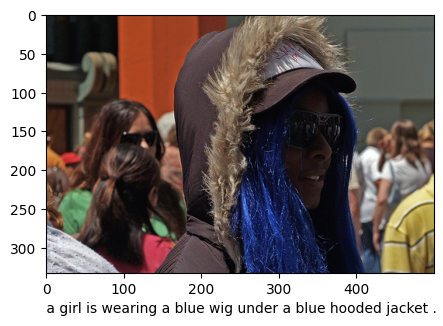

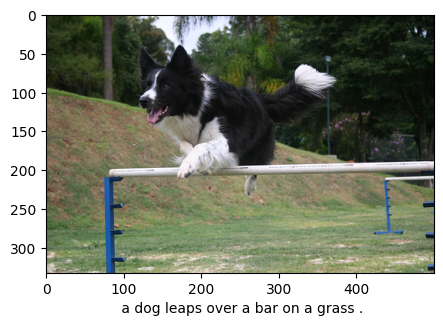

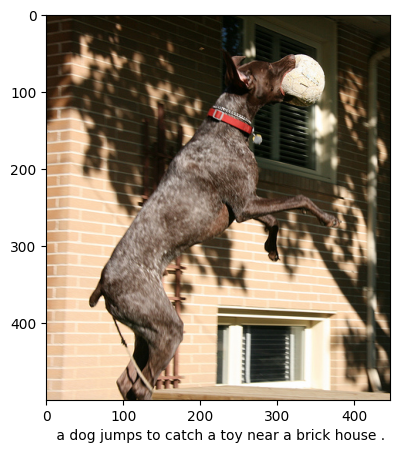

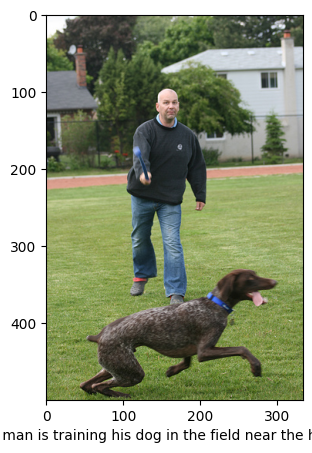

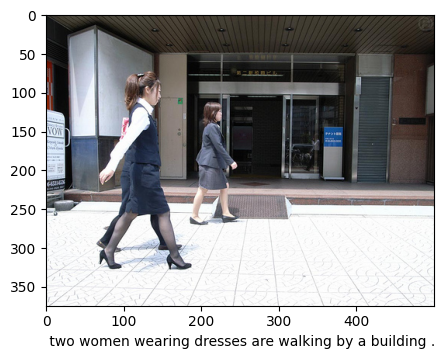

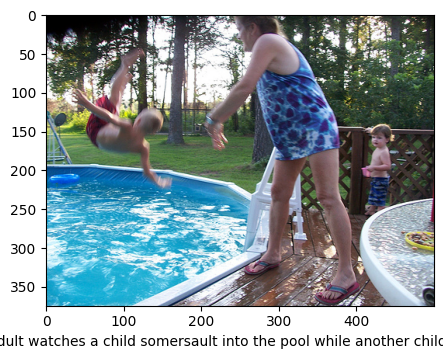

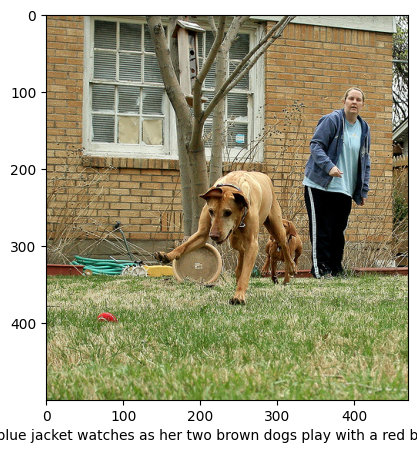

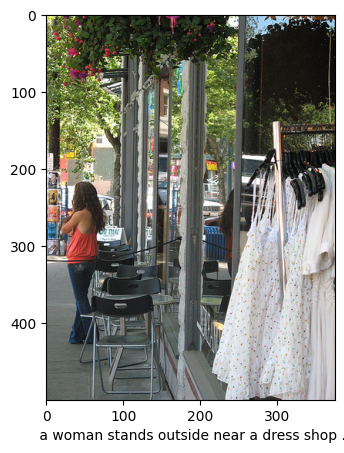

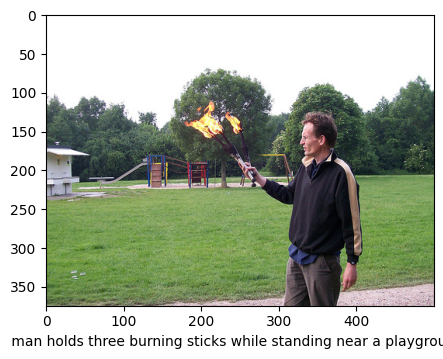

In [38]:
for i in range(10):
    random_no = np.random.randint(0,1501,(1,1))[0,0]
    test_feature = model.predict(getImage(random_no)).reshape(1,2048)
    test_img_path = images[random_no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    pred_text = ['startofseq']
    count = 0
    caption = '' # Stores the predicted captions text
    
    while count < 25:
        count += 1
        # Encoding the captions text with numbers
        encoded = []
        
        for i in pred_text:
            encoded.append(count_words[i])
        
        encoded = [encoded]
        # Padding the encoded text sequences to maximum length
        encoded = pad_sequences(encoded,maxlen=MAX_LEN,padding='post',truncating='post')
        pred_idx = np.argmax(final_model.predict([test_feature,encoded])) # Fetching the predicted word index having the maximum probability of occurrence
        sampled_word = inverse_dict[pred_idx] # Extracting the predicted word by its respective index
        # Checking for ending of the sequence
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word)
    
    plt.figure(figsize=(5,5))
    plt.imshow(test_img)
    plt.xlabel(caption)


In [39]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('nltk_contrib')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Error loading nltk_contrib: Package 'nltk_contrib' not
[nltk_data]     found in index


False

In [40]:
import nltk
from nltk.translate.bleu_score import sentence_bleu


In [41]:
reference_captions = []
generated_captions = []


In [75]:
reference_captions.append([caption])
generated_captions.append(caption)



In [76]:
print(reference_captions)

[[' man holds three burning sticks while standing near a playground .'], [' man holds three burning sticks while standing near a playground .'], [' man holds three burning sticks while standing near a playground .'], [' man holds three burning sticks while standing near a playground .'], [' man holds three burning sticks while standing near a playground .'], [' man holds three burning sticks while standing near a playground .'], [' man holds three burning sticks while standing near a playground .'], [' man holds three burning sticks while standing near a playground .'], [' man holds three burning sticks while standing near a playground .'], [' man holds three burning sticks while standing near a playground .'], [' man holds three burning sticks while standing near a playground .']]


In [77]:
bleu_scores = []
for i in range(len(generated_captions)):
    reference = reference_captions[i]
    candidate = generated_captions[i]
    score = sentence_bleu(reference, candidate)
    bleu_scores.append(score)


In [78]:
avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU score:", avg_bleu_score)


Average BLEU score: 0.125
